In [2]:
%matplotlib inline

import re, sys, os, json
import matplotlib as mpl
import numpy as np, matplotlib.pyplot as plt
import seaborn as sns, pandas as pd
from glob import glob
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict

mpl.rcParams['font.sans-serif'] = ['Arial']

# Initialization

In [3]:
in_path = r'/mnt/cfs/med18b/med_rd/danxu/History_Stat/YuceOne_Plus'
bad_pair_file = in_path + r'/bad_pair_list'
outdir = in_path + r'/stat_output'
if not os.path.exists(outdir): os.mkdir(outdir)

In [4]:
skip_samples = []
tmp = []
with open(bad_pair_file, 'r') as f:
    for l in f:
        skip_samples.append(l.strip())
        tmp.extend(l.strip().split('-VS-'))
skip_samples.extend(tmp)

In [5]:
def skip_file(files):
    del_files = []
    for i in files:
        for s in skip_samples:
            if re.search(s, i):
                del_files.append(i)
                break
    for i in del_files:
        files.remove(i)
        
def read_refgene_txt():
    dic = {}
    gene_chr = {}
    txt_file = r'/mnt/nfs/database/hg19/ucsc/refgene.20171024.txt'
    with open(txt_file, 'r') as f:
        for l in f:
            if re.match('^#', l): continue
            l = l.split('\t')
            gname = l[-4]
            if dic.get(gname): continue
            starts = l[9].split(','); starts.remove('')
            ends = l[10].split(','); ends.remove('')
            dic[gname] = list(zip(starts, ends))
            gene_chr[gname] = l[2]
    return(dic, gene_chr)

def file_lineNum(file):
    with open(file) as f:
        i = 0
        for i, l in enumerate(f):
            pass
    return i + 1

In [6]:
gene_dic, gene_chr = read_refgene_txt()

# 热点，HLA，MHC

## 1. 突变热点

In [7]:
#get snp, indel files
fpath = in_path + r'/somatic/overlap'
files = glob(fpath + '/*/*snv.sindel.AAchange.xls')
skip_file(files)
hot_spot_outdir = outdir + r'/hotspot'
if not os.path.exists(hot_spot_outdir): os.mkdir(hot_spot_outdir)

In [8]:
hotspot1 = defaultdict(int)
hotspot2 = defaultdict(dict)
for i in files:
    with open(i, 'r') as f:
        for l in f:
            if re.match('^Chr', l): continue
            l = l.split('\t'); 
            pos = l[0]+'_'+l[1];
            hotspot1[pos] += 1
            info = '%s,%s,%s' %(l[9], l[5], l[6])
            hotspot2[pos][info] = ''
hotspot1 = sorted(hotspot1.items(), key = lambda k:k[1], reverse=True)

In [9]:
with open(hot_spot_outdir + '/hotspot', 'w') as f:
    f.write('Pos\tCount\tInfo\n')
    for k,v in hotspot1:
        info = " | ".join(hotspot2[k].keys())
        f.write("%s\t%d\t%s\n" %(k, v, info))

## 4.	各种HLA基因型在人群中所占频率

In [10]:
hla_path = in_path + '/hla/overlap'
hla1_files = glob(hla_path + '/*/*hla1.result')
hla2_files = glob(hla_path + '/*/*hla2.result')
skip_file(hla1_files); skip_file(hla2_files)
hla_outdir = outdir + '/HLA_type_frequence'
if not os.path.exists(hla_outdir): os.mkdir(hla_outdir)

In [11]:
f_h1 = os.popen('cat ' +  ' '.join(hla1_files))
hla1 = defaultdict(int)
for l in f_h1:
    if not l: continue
    l = np.unique(l.strip().split(','))
    for i in l:
        hla1[i] += 1

hla1 = sorted(hla1.items(), key = lambda k:k[1], reverse=True)
f_h1.close()

f_h2 = os.popen('cat ' +  ' '.join(hla2_files))
hla2 = defaultdict(int)
for l in f_h2:
    if not l: continue
    l = np.unique(l.strip().split(','))
    for i in l:
        hla2[i] += 1

hla2 = sorted(hla2.items(), key = lambda k:k[1], reverse=True)
f_h2.close()

In [12]:
with open(hla_outdir + '/HLA1', 'w') as f:
    for k,v in hla1:
        f.write("%s\t%d\t%.2f%%\n" %(k, v, v/len(hla1_files) * 100))
        
with open(hla_outdir + '/HLA2', 'w') as f:
    for k,v in hla2:
        f.write("%s\t%d\t%.2f%%\n" %(k, v, v/len(hla2_files) * 100))

## 5.	新抗原

In [7]:
mhc_path = in_path + '/mhc'
mhc1_files = glob(mhc_path + '/MHCIanno/*/*final.report.txt')
mhc2_files = glob(mhc_path + '/MHCIIanno/*/*final.report.txt')
skip_file(mhc1_files); skip_file(mhc2_files)
mhc_outdir = outdir + '/MHC_feq'
if not os.path.exists(mhc_outdir): os.mkdir(mhc_outdir)

### 5.1 多个样本中均出现的新抗原

In [16]:
mhc1 = defaultdict(int)
mhc1_info = defaultdict(dict)
for i in mhc1_files:
    with open(i, 'r') as f:
        dic_pos = {}
        for l in f:
            if re.match('^NeoRank|None', l): continue
            l = l.split('\t')
            pos = f'{l[9]}_{l[10]}'
            if dic_pos.get(pos):
                continue
            dic_pos[pos] = 1
            mhc1[pos] += 1
            info = '%s,%s,%s,%s' %(l[8], l[13], l[2], l[3])
            mhc1_info[pos].setdefault(info, 0)
            mhc1_info[pos][info] += 1

mhc1 = sorted(mhc1.items(), key = lambda k:k[1], reverse=True)

In [17]:
mhc2 = defaultdict(int)
mhc2_info = defaultdict(dict)
for i in mhc2_files:
    with open(i, 'r') as f:
        dic_pos = {}
        for l in f:
            if re.match('^NeoRank|None', l): continue
            l = l.split('\t')
            pos = f'{l[9]}_{l[10]}'
            if dic_pos.get(pos):
                continue
            dic_pos[pos] = 1
            mhc2[pos] += 1
            info = '%s,%s,%s,%s' %(l[8], l[13], l[2], l[3])
            mhc2_info[pos].setdefault(info, 0)
            mhc2_info[pos][info] += 1

mhc2 = sorted(mhc2.items(), key = lambda k:k[1], reverse=True)

In [21]:
with open(mhc_outdir + '/MHC1', 'w') as f:
    f.write('Pos\tCount\tInfo\n')
    for k,v in mhc1:
        sort_info = sorted(mhc1_info[k].items(), key = lambda k:k[1], reverse=True)
        info = [f'{k}({v})' for k,v in sort_info]
        info = " | ".join(info)
        f.write("%s\t%d\t%s\n" %(k, v, info))

with open(mhc_outdir + '/MHC2', 'w') as f:
    f.write('Pos\tCount\tInfo\n')
    for k,v in mhc2:
        sort_info = sorted(mhc2_info[k].items(), key = lambda k:k[1], reverse=True)
        info = [f'{k}({v})' for k,v in sort_info]
        info = " | ".join(info)
        f.write("%s\t%d\t%s\n" %(k, v, info))

### 5.2 新抗原所在的基因统计

#### 癌肿TNB

In [109]:
path_2018 = '/mnt/cfs/med18b/med_rd/danxu/History_Stat_2018only/YuceOne_Plus'
mhc_path = path_2018 + '/mhc'
mhc1_files = glob(mhc_path + '/MHCIanno/*/*final.report.txt')
mhc2_files = glob(mhc_path + '/MHCIIanno/*/*final.report.txt')
skip_file(mhc1_files); skip_file(mhc2_files)

#REad 2018 samples cancer type
file = '/home/danxu/2.files/History_Stat/Sample_CancerType.xlsx'
df = pd.read_excel(file, header=None, names=['sample','cancer','type'])
df.fillna('NA', inplace=True)

c_dic = {'肺':'肺癌', '食管|食道':'食管癌','胃':'胃癌', '卵巢':'卵巢癌','宫颈':'宫颈癌', '结肠|直肠':'结直肠癌',
         '乳腺':'乳腺癌', '鼻咽':'鼻咽癌','膀胱':'膀胱癌', '肾':'肾癌','肝':'肝癌'}
def cancer_type_rec(c_in, c_dic):
    for i in c_dic.keys():
        if re.search(r'\+|,|、', c_in):
            return('多种肿瘤')
        elif re.search(i, c_in):
            return(c_dic[i])
    else:
        return('其他')

In [110]:
# read cancer_type
dic_sample_cancer_ref = {}
for k,v in zip(df['sample'].values, df['cancer'].values):
    dic_sample_cancer_ref[k] = cancer_type_rec(v, c_dic)

dic_sample_cancer = {}
j_file = f'{in_path}/2018.YuceOne_Plus.json'
with open(j_file, 'r') as f:
    js = json.load(f)
    for pair in js['somatic']:
        me = re.match(r'(\S+)-VS-(\S+)', pair)
        s1 = me.group(1)
        s2 = me.group(2)
        pair2 = f'{s2}-VS-{s1}'
        if js['sample'][s1]['ctype'] != 'Unkown':
            dic_sample_cancer[pair] = cancer_type_rec(js['sample'][s1]['ctype'], c_dic)
            dic_sample_cancer[pair2] = cancer_type_rec(js['sample'][s1]['ctype'], c_dic)
        elif js['sample'][s2]['ctype'] != 'Unkown':
            dic_sample_cancer[pair] = cancer_type_rec(js['sample'][s2]['ctype'], c_dic)
            dic_sample_cancer[pair2] = cancer_type_rec(js['sample'][s2]['ctype'], c_dic)
        elif s1 in dic_sample_cancer_ref:
            dic_sample_cancer[pair] = dic_sample_cancer_ref[s1]
            dic_sample_cancer[pair2] = dic_sample_cancer_ref[s1]
        elif s2 in dic_sample_cancer_ref:
            dic_sample_cancer[pair] = dic_sample_cancer_ref[s2]
            dic_sample_cancer[pair2] = dic_sample_cancer_ref[s2]
        else:
            dic_sample_cancer[pair] = 'Unknown'
            dic_sample_cancer[pair2] = 'Unknown'

In [491]:
from collections import Counter
Counter(list(dic_sample_cancer.values()))

Counter({'肺癌': 246,
         '肝癌': 28,
         '食管癌': 20,
         '胃癌': 30,
         '宫颈癌': 8,
         '乳腺癌': 20,
         'Unknown': 4,
         '其他': 86,
         '结直肠癌': 46,
         '卵巢癌': 10,
         '膀胱癌': 4,
         '肾癌': 6,
         '多种肿瘤': 2})

In [111]:
mhc1 = defaultdict(list)
for i in mhc1_files:
    me = re.search(r'/([^/]+-VS-[^/]+)/', i)
    pair_name = me.group(1)
    with open(i, 'r') as f:
        dic_pos = {}
        for l in f:
            if re.match('^NeoRank|None', l): continue
            l = l.strip().split('\t')
            pos = f'{l[9]}_{l[10]}'
            if dic_pos.get(pos):
                continue
            dic_pos[pos] = 1
            mhc1['pair'].append(pair_name)
            mhc1['cancer_type'].append(dic_sample_cancer[pair_name])
            mhc1['Count'].append(1)
            
            #mhc1['Type'].append('MHC1')

df_mhc = pd.DataFrame(mhc1, index=list(range(len(mhc1['pair']))))

In [112]:
most_ct = ['肺癌','肝癌','食管癌','胃癌','结直肠癌']
f_ct_plot = df_mhc.groupby(['cancer_type', 'pair']).agg('sum').reset_index()
f_ct_plot = f_ct_plot[f_ct_plot['cancer_type'].isin(most_ct)]
f_ct_plot['Count'] = f_ct_plot['Count']/1.5
num_od = f_ct_plot.groupby('cancer_type').agg(np.median).sort_values('Count').index

In [88]:
f_ct_plot.cancer_type.value_counts()

肺癌      46
结直肠癌    17
胃癌      11
肝癌       8
食管癌      6
Name: cancer_type, dtype: int64

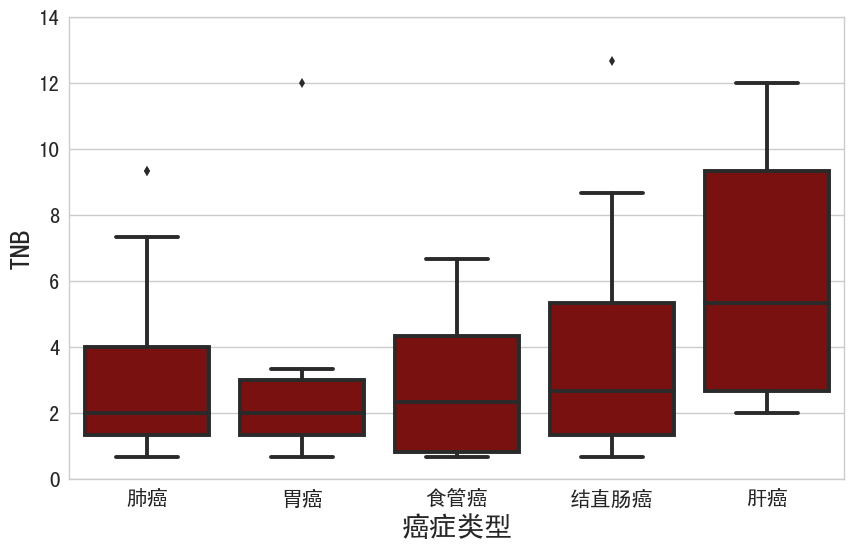

In [120]:
f,ax = plt.subplots(figsize=(10,6))
sns.set(style="whitegrid", font='simhei')
sns.boxplot(data=f_ct_plot, x='cancer_type', y='Count', color='darkred', linewidth=2.8,
            order=num_od, ax=ax)
ax.set_xlabel(u'癌症类型', fontsize=20)
ax.set_ylabel('TNB', fontsize=20)
ax.tick_params(labelsize=15)
ax.set_ylim(0,14)
plt.savefig('/mnt/cfs/med18b/med_rd/danxu/History_Stat/YuceOne_Plus/stat_output/imgs/ct_TNB.png', dpi=100 ,bbox_inches='tight')

#### Gene&TNB

In [66]:
'''def hla_type_value(hlatype):
    if hlatype == 'HLA-A':
        return(0.5)
    elif hlatype == 'HLA-B':
        return(1)
    elif hlatype == 'HLA-C':
        return(1.5)'''
    
mhc1 = defaultdict(list)
for i in mhc1_files:
    me = re.search(r'/([^/]+-VS-[^/]+)/', i)
    pair_name = me.group(1)
    with open(i, 'r') as f:
        dic_pos = {}
        for l in f:
            if re.match('^NeoRank|None', l): continue
            l = l.strip().split('\t')
            pos = f'{l[9]}_{l[10]}'
            if dic_pos.get(pos):
                continue
            dic_pos[pos] = 1
            me = re.search(r'^(HLA-\w\*\d{2})', l[2])
            hlatype = me.group(1)
            mhc1['HLA_Type'].append(hlatype)
            #mhc1['HLA_Type_Value'].append(hla_type_value(hlatype))
            mhc1['pair'].append(pair_name)
            mhc1['pos'].append(pos)
            mhc1['gname'].append(l[8])
            mhc1['clonal'].append(l[-1])
            mhc1['Count'].append(1)
            mhc1['Protein_change'].append(l[13])
            
            #mhc1['Type'].append('MHC1')

df_mhc = pd.DataFrame(mhc1, index=list(range(len(mhc1['pair']))))
df_mhc.loc[-df_mhc.clonal.isin(['clonal','subclonal']), 'clonal'] = 'Unknown'

In [67]:
most_pos_gene = ['KRAS','EGFR','SEC14L2','KDM5A','PIK3CA','TP53','EGFR']
df_mpg = df_mhc[df_mhc['gname'].isin(most_pos_gene) & (df_mhc.clonal == 'clonal')]
df_mpg.head()

,Count,HLA_Type,Protein_change,clonal,gname,pair,pos
1,1,HLA-A*11,p.L858R,clonal,EGFR,17R01631-VS-17R01630,7_55259515
118,1,HLA-A*11,p.A146T,clonal,KRAS,18A00505SL01-VS-18B00505XY01,12_25378562
171,1,HLA-B*40,p.G12V,clonal,KRAS,18A00344AZ01-VS-18B00344XY01,12_25398284
192,1,HLA-A*33,p.R209Q,clonal,TP53,18A00406AZ01-VS-18B00406XY01,17_7577538
196,1,HLA-A*11,p.A289V,clonal,EGFR,17R00871-VS-17R00870,7_55221822


In [69]:
dg = df_mpg.groupby(['gname','pos'])
dg.HLA_Type.value_counts()

gname   pos                 HLA_Type
EGFR    7_55221732          HLA-B*15    1
        7_55221822          HLA-A*11    1
        7_55241734          HLA-A*24    1
        7_55242465          HLA-A*30    1
        7_55242469          HLA-A*11    1
        7_55249012          HLA-A*02    1
        7_55249071          HLA-A*02    1
        7_55259515          HLA-A*11    4
                            HLA-A*30    1
                            HLA-A*31    1
                            HLA-C*15    1
KDM5A   12_419109           HLA-B*15    1
        12_420092           HLA-A*11    1
KRAS    12_25378562         HLA-A*11    2
        12_25380310         HLA-B*40    1
        12_25398281         HLA-A*02    1
                            HLA-A*11    1
        12_25398284         HLA-A*02    2
                            HLA-A*11    2
                            HLA-B*40    2
PIK3CA  3_178916876         HLA-A*31    1
        3_178927439         HLA-B*35    1
        3_178936082         HLA-A*30   

In [74]:
# pair clone count
df_count = df_mhc.groupby(['pair','clonal']).Count.count()
df_count = pd.DataFrame(df_count).reset_index()
df_count.head()

,pair,clonal,Count
0,17R000001-VS-17R000002,clonal,1
1,17R000001-VS-17R000002,subclonal,41
2,17R000003-VS-17R000004,subclonal,7
3,17R000005-VS-17R000006,clonal,7
4,17R000005-VS-17R000006,subclonal,3


In [75]:
df_plot = pd.pivot_table(df_count[df_count.clonal.isin(['clonal','subclonal'])], values='Count', index='pair', columns='clonal').fillna(0)
df_plot = df_plot / 1.5
df_plot = df_plot.sort_values('clonal', ascending=False)

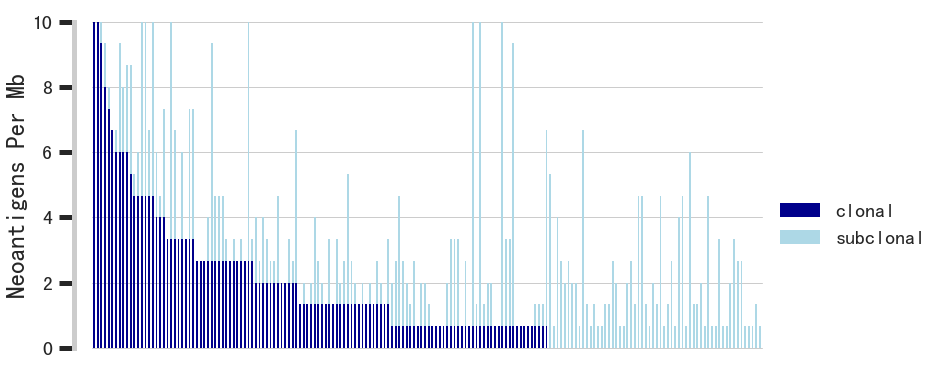

In [127]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
df_plot.plot(kind='bar', ylim=(0,10), stacked=True, color=['darkblue','lightblue'] ,ax=ax)
#ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_position(('outward', 18))
ax.spines['left'].set_linewidth(5)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylabel('Neoantigens Per Mb', size=25)
ax.tick_params(labelsize=20, length=15, width=5)
ax.legend(title=False, frameon=False, loc='upper left',bbox_to_anchor=(1.0,0.5), fontsize=20)

In [100]:
# top10 genes distribution in pairs
df_gene_plot = pd.pivot_table(df_mhc, values='Count', index='pair', columns='gname', fill_value=0)
df_gene_plot = df_gene_plot.reindex(list(df_plot.index))
top10_gene = df_gene_plot.sum().sort_values(ascending=False).index[:10]
df_gene_plot = df_gene_plot[top10_gene]
df_gene_plot.head()

gname,TP53,EGFR,KRAS,KDM5A,PIK3CA,BRCA2,PTEN,FAT1,ATM,FAT4
pair,,,,,,,,,,
YC1700033-VS-YC1700034,0,0,1,0,1,0,1,1,0,0
YC1700136-VS-YC1700135,0,0,0,1,0,0,1,0,1,1
18A00277AZ01-VS-18B00277XY01,0,0,0,0,0,0,0,0,0,0
18A00344AZ01-VS-18B00344XY01,0,0,1,0,0,0,0,0,0,0
18A00250AZ01-VS-18B00250XY01,0,0,0,0,0,0,0,0,0,0


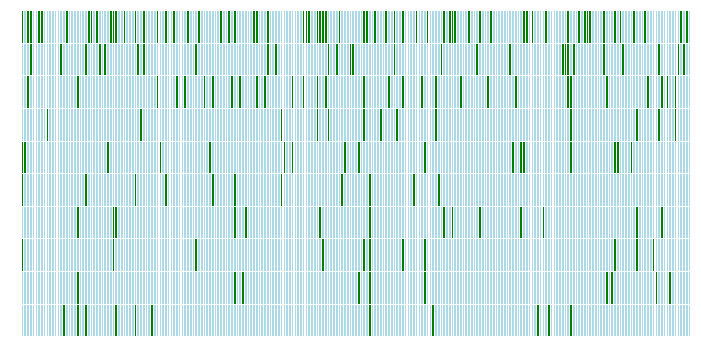

In [288]:
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df_gene_plot.T, linewidths=0.05, cbar=False, xticklabels=False, yticklabels=False, cmap=['lightblue','green'], ax=ax)
ax.axis('off')
plt.show()

In [103]:
gene_neo_per = df_gene_plot.sum()/df_gene_plot.shape[0]*100
gene_neo_per = np.round(gene_neo_per,2)

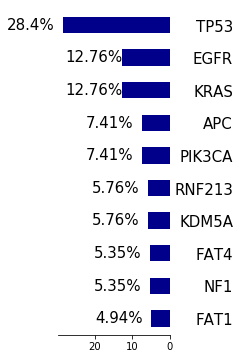

In [416]:
'''plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off'''

ax = gene_neo_per.plot(kind='barh', color='darkblue', figsize=(2,6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
for p in ax.patches:
    ax.text(p.get_width()+15, p.get_y()+.38, str(p.get_width())+'%', fontsize=15)
ax.axes.invert_xaxis()
ax.axes.invert_yaxis()
ax.tick_params(axis='y',labelsize=15, length=0, width=0)
ax.spines['left'].set_position(('axes', 1.6))
ax.margins(y=1)
#ax.set_yticklabels([f'{i}%' for i in gene_neo_per])
plt.show()

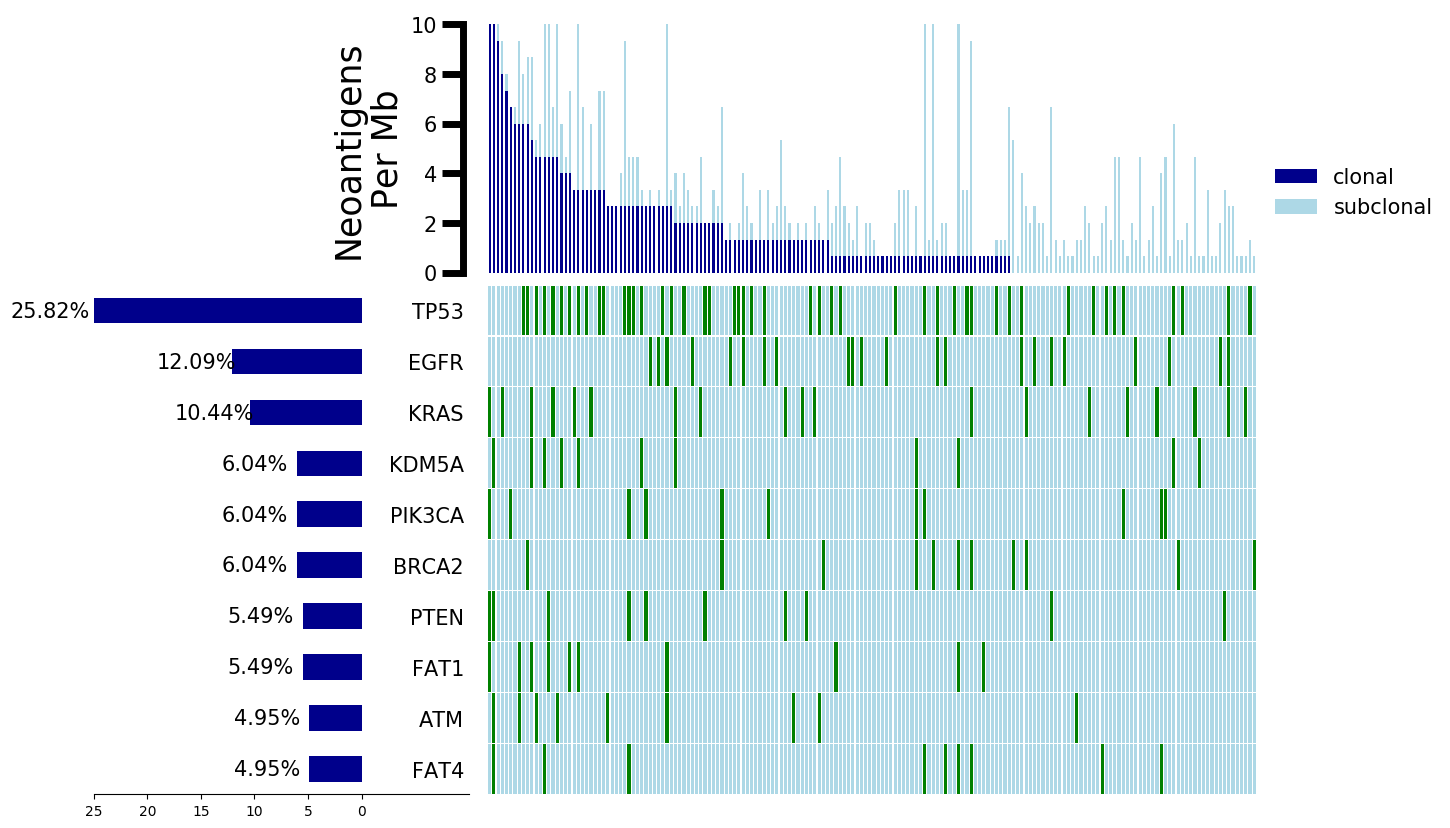

In [108]:
mpl.style.use('default')
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(3, 3, wspace=0.05, hspace=0.05)

ax_Neos = fig.add_subplot(grid[0,1:])
df_plot.plot(kind='bar', ylim=(0,10), stacked=True, color=['darkblue','lightblue'], ax=ax_Neos)
#ax_Neos.axis('off')
ax_Neos.spines['top'].set_visible(False)
ax_Neos.spines['right'].set_visible(False)
ax_Neos.spines['bottom'].set_visible(False)
ax_Neos.spines['left'].set_position(('outward', 18))
ax_Neos.spines['left'].set_linewidth(5)
ax_Neos.set_xlabel('')
ax_Neos.set_xticks([])
ax_Neos.set_xticklabels([])
ax_Neos.set_ylabel(f'Neoantigens\nPer Mb', size=25)
ax_Neos.tick_params(labelsize=15, length=15, width=5)
ax_Neos.legend(title=False, frameon=False, loc='upper left',bbox_to_anchor=(1.0,0.5), fontsize=15)

ax_gene_tile = fig.add_subplot(grid[1:,1:])
sns.heatmap(df_gene_plot.T, linewidths=0.05, cbar=False, xticklabels=False, yticklabels=False, cmap=['lightblue','green'], ax=ax_gene_tile)
ax_gene_tile.spines['top'].set_visible(False)
ax_gene_tile.spines['right'].set_visible(False)
ax_gene_tile.spines['bottom'].set_visible(False)
ax_gene_tile.spines['left'].set_visible(False)
ax_gene_tile.axis('off')

ax_gene_per = fig.add_subplot(grid[1:,0])
gene_neo_per.plot(kind='barh', color='darkblue', ax=ax_gene_per, xlim=(-10,25))
ax_gene_per.set_ylabel('')
ax_gene_per.spines['top'].set_visible(False)
ax_gene_per.spines['right'].set_visible(False)
ax_gene_per.spines['left'].set_visible(False)
for p in ax_gene_per.patches:
    ax_gene_per.text(p.get_width()+7, p.get_y()+.38, str(p.get_width())+'%', fontsize=15)
ax_gene_per.set_xticks(np.arange(0,26, step=5))
ax_gene_per.axes.invert_xaxis()
ax_gene_per.axes.invert_yaxis()
ax_gene_per.tick_params(axis='y', labelsize=15, length=0, width=0)
ax_gene_per.spines['left'].set_position(('axes', 1))
#ax_gene_per.set_yticklabels([f'{i}%' for i in gene_neo_per])
plt.savefig('/mnt/cfs/med18b/med_rd/danxu/History_Stat/YuceOne_Plus/stat_output/imgs/Neos.png', dpi=100 ,bbox_inches='tight')

#### TMB&TNB

In [8]:
mhc1_path = mhc_path + r'/MHCIanno'
os.chdir(mhc1_path)
pairs = !ls
skip_file(pairs)

tnb_tmb = defaultdict(list)

for pair in pairs:
    mhcfile = glob(f'{pair}/*final.report.txt')[0]
    AApath = f'{in_path}/somatic/overlap/'
    AAfile = glob(f'{AApath}/{pair}/*snv.sindel.AAchange.xls')[0]
    if file_lineNum(mhcfile) <= 1:
        continue
    with open(mhcfile, 'r') as f:
        dic_pos = {}
        num = 0
        for l in f:
            if re.match('^NeoRank|None', l): continue
            l = l.strip().split('\t')
            pos = f'{l[9]}_{l[10]}'
            if dic_pos.get(pos):
                continue
            dic_pos[pos] = 1
            num += 1
        tnb_tmb['TMB'].append(file_lineNum(AAfile) - 1)
        tnb_tmb['TNB'].append(num)

df_tmb_tnb = pd.DataFrame(tnb_tmb)
df_tmb_tnb = df_tmb_tnb / 1.5
df_tmb_tnb.head()

,TMB,TNB
0,61.333333,28.000000
1,7.333333,4.666667
2,12.000000,6.666667
3,6.666667,4.000000
4,4.000000,2.000000


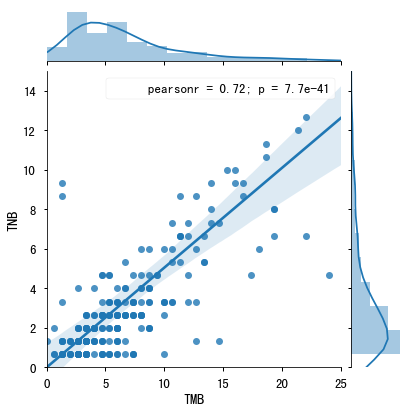

In [35]:
#sns.set_context(rc={"font.size":12, '')
sns.set_context("notebook", font_scale=1.3)

#plt.figure(figsize=(10,10))
sns.jointplot(data=df_tmb_tnb, x='TMB', y='TNB', kind='reg', xlim=(0,25), ylim=(0,15))
#ax.set_xlabel('TMB', fontsize=20)
#ax.set_ylabel('TNB', fontsize=20)
#ax.tick_params(size=15)
plt.savefig('/mnt/cfs/med18b/med_rd/danxu/History_Stat/YuceOne_Plus/stat_output/imgs/TMB-TNB.png', dpi=100 ,bbox_inches='tight')

# 外显子相关

## Build Matirx

In [6]:
exome_path = in_path + '/somatic/overlap'
exome_outdir = outdir + '/Exon'
os.makedirs(exome_outdir, exist_ok=True)
os.chdir(exome_path)
sample_pair = glob('*')
skip_file(sample_pair)

In [7]:
all_exome = []
exome_mut = {}
exon_pos = defaultdict(str)
exome_info = defaultdict(dict)
for pair in sample_pair:
    file = glob(f'{pair}/*snv.sindel.AAchange.xls')[0]
    exome_mut[pair] = {}
    with open(file, 'r') as f:
        for l in f:
            if re.match('^Chr', l): continue
            l = l.split('\t')
            pos = l[1]; gname = l[5]
            exon = 0
            if gname in gene_dic:
                for p1,p2 in gene_dic[gname]:
                    exon+=1
                    if pos>=p1 and pos<=p2:
                        key = "%s_%s" %(gname, exon)
                        exome_mut[pair].setdefault(key, 0)
                        exome_mut[pair][key] += 1
                        all_exome.append(key)
                        info ="%s" %(l[9])
                        exon_pos[key] = "%s-%s" %(p1, p2)
                        exome_info[key][info] = ''
                        break

all_exome = np.unique(all_exome)
for k1 in exome_mut:
    for k2 in all_exome:
        exome_mut[k1].setdefault(k2, 0)

In [8]:
exome_df = pd.DataFrame(exome_mut).T
exome_df.head()

,ABCB1_1,ABCB1_10,ABCB1_14,ABCB1_19,ABCB1_20,ABCB1_23,ABCB1_25,ABCB1_27,ABCB1_9,ABI1_1,...,ZFHX3_9,ZFHX4_10,ZNF233_5,ZNF331_7,ZNF384_4,ZNF521_5,ZNF793_8,ZNF844_4,ZRSR2_3,ZRSR2_4
17R01631-VS-17R01630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17R00945-VS-17R00944,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
18A00183XJ01-VS-18B00183XY01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18A00230SL01-VS-18B00230XY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YC1700152-VS-YC1700151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. 更容易出现体细胞突变的外显子

In [31]:
most_mut = exome_df.sum().sort_values(ascending=False)
Chr = pd.Series([gene_chr[re.sub('_\d+', '', i)] for i in most_mut.index], index=most_mut.index)
Pos = pd.Series([exon_pos[i] for i in most_mut.index], index=most_mut.index)
Info = pd.Series([" | ".join(exome_info[i].keys()) for i in most_mut.index], index=most_mut.index)
most_mut = pd.concat([most_mut, Chr, Pos, Info], axis=1, keys=['count', 'Chr', 'Pos', 'Info'])
#percentage = most_mut / len(sample_pair)
#df_out = pd.concat([most_mut, percentage], axis=1, keys=['count', 'percentage'])
most_mut.to_csv(exome_outdir + '/the_most_mut_exons', sep='\t', index_label='Exon')

## 3. 在体细胞突变的发生概率在人群中差异较大的外显子（更与TMB相关）

### Variation

In [14]:
exome_var = exome_df.var().sort_values(ascending=False)
Chr = [gene_chr[re.sub('_\d+', '', i)] for i in exome_var.index]
Pos = [exon_pos[i] for i in exome_var.index]
exome_var = pd.DataFrame({'Chr':Chr, 'Pos':Pos, 'Mutation_Variation':exome_var.values}, index=exome_var.index)
exome_var.to_csv(exome_outdir + '/most_various_exon_byVar', sep='\t', index_label='Exon')

### Outliers

In [15]:
#d_arr = squareform(pdist(exome_df.T, 'euclidean'))
#d_df_euc = pd.DataFrame(d_arr, columns=exome_df.columns, index=exome_df.columns)

d_arr = squareform(pdist(exome_df.T, 'cosine'))
d_df_cos = pd.DataFrame(d_arr, columns=exome_df.columns, index=exome_df.columns)

## 马氏距离计算中，协方差矩阵不可逆，抛弃
#d_arr = squareform(pdist(exome_df.T, 'mahalanobis'))
#d_df_ma = pd.DataFrame(d_arr, columns=exome_df.columns, index=exome_df.columns)

In [16]:
#exome_outlier_euc = d_df_euc.sum().sort_values(ascending=False)
#exome_outlier_euc.to_csv(exome_outdir + '/most_various_exon_byEuclidean', sep='\t', header=['Euclidean_dis'])

exome_outlier_cos = d_df_cos.sum().sort_values(ascending=True)
Chr = [gene_chr[re.sub('_\d+', '', i)] for i in exome_outlier_cos.index]
Pos = [exon_pos[i] for i in exome_outlier_cos.index]
exome_outlier_cos = pd.DataFrame({'Chr':Chr, 'Pos':Pos, 'Cosine_dis':exome_outlier_cos.values}, index=exome_outlier_cos.index)
exome_outlier_cos.to_csv(exome_outdir + '/most_various_exon_byCosine', sep='\t', index_label='Exon')

#all_method_exon = pd.DataFrame({ 'Variation':exome_var.index, 'Euclidean':exome_outlier_euc.index, 'Cosine':exome_outlier_cos.index })
#all_method_exon.to_csv(exome_outdir + '/most_various_exon_All_Method', sep='\t')

## 6.	是否存在某些外显子更容易出现新抗原（发生频率更高）？

In [37]:
mhc_path = in_path + '/mhc'
exon_mhc1_files = glob(mhc_path + '/MHCIanno/*/*final.report.txt')
exon_mhc2_files = glob(mhc_path + '/MHCIIanno/*/*final.report.txt')
skip_file(exon_mhc1_files); skip_file(exon_mhc2_files)

In [38]:
exon_mhc1 = {}
exon_mhc1_info = defaultdict(dict)
dic_pos = {}
for i in exon_mhc1_files:
    with open(i, 'r') as f:
        for l in f:
            if re.match('^NeoRank|None', l): continue
            l = l.split('\t')
            chr_pos = f'{l[9]}_{l[10]}'
            if dic_pos.get(chr_pos):
                continue
            gname = l[8]
            pos = l[10]
            dic_pos[chr_pos] = 1
            exon = 0
            if gname in gene_dic:
                for p1,p2 in gene_dic[gname]:
                    exon+=1
                    if pos>=p1 and pos<=p2:
                        gname = "%s_%s" %(gname, exon)
                        info = "%s,%s" %(l[12], l[2])
                        Chr = gene_chr[re.sub('_\d+', '', gname)]
                        rep_info = "%s_%s-%s" %(Chr, p1, p2)
                        exon_mhc1.setdefault(gname, 0)
                        exon_mhc1[gname] += 1
                        exon_mhc1_info[gname][info] = rep_info
                        break
exon_mhc1 = sorted(exon_mhc1.items(), key = lambda k:k[1], reverse=True)

In [39]:
exon_mhc2 = {}
exon_mhc2_info = defaultdict(dict)
dic_pos = {}
for i in exon_mhc2_files:
    with open(i, 'r') as f:
        for l in f:
            if re.match('^NeoRank|None', l): continue
            l = l.split('\t')
            chr_pos = f'{l[9]}_{l[10]}'
            if dic_pos.get(chr_pos):
                continue
            gname = l[8]
            pos = l[10]
            dic_pos[chr_pos] = 1
            exon = 0
            if gname in gene_dic:
                for p1,p2 in gene_dic[gname]:
                    exon+=1
                    if pos>=p1 and pos<=p2:
                        gname = "%s_%s" %(gname, exon)
                        info = "%s,%s" %(l[12], l[2])
                        Chr = gene_chr[re.sub('_\d+', '', gname)]
                        rep_info = "%s_%s-%s" %(Chr, p1, p2)
                        exon_mhc2.setdefault(gname, 0)
                        exon_mhc2[gname] += 1
                        exon_mhc2_info[gname][info] = rep_info
                        break
exon_mhc2 = sorted(exon_mhc2.items(), key = lambda k:k[1], reverse=True)

In [40]:
with open(exome_outdir + '/exon_mhc1_freq', 'w') as f:
    f.write("Exon\tCount\tInfo\n")
    for k,v in exon_mhc1:
        info = list(exon_mhc1_info[k].values())[0] + "\t" + " | ".join(exon_mhc1_info[k].keys())
        f.write("%s\t%d\t%s\n" %(k, v, info))

In [41]:
with open(exome_outdir + '/exon_mhc2_freq', 'w') as f:
    f.write("Exon\tCount\tInfo\n")
    for k,v in exon_mhc2:
        info = list(exon_mhc2_info[k].values())[0] + "\t" + " | ".join(exon_mhc2_info[k].keys())
        f.write("%s\t%d\t%s\n" %(k, v, info))

# 7.	捕获芯片上测序深度较低的区域

In [ ]:
#header.extend(['s' + str(i+1) for i in range(96)])
#wheader = "\t".join(header) + '\n'

t_dep_outdir = outdir + '/depth_capture'
if not os.path.exists(t_dep_outdir):
    os.mkdir(t_dep_outdir)
#dep_out = t_dep_outdir + '/dep_out'
#cov_out = t_dep_outdir + '/cov_out'

In [ ]:
depth_file = glob(in_path + r'/alignment/depth_result*/depth_file_sub*')

# 计算每个区域的深度、覆盖度
for file in depth_file:
    dep_out = file + '.dep_out'
    cov_out = file + '.cov_out'
    fd = open(dep_out, 'w')
    fc = open(cov_out, 'w')
    dep = []
    previous = 0
    Chr, star, end = ['', 0, 0]
    with open(file, 'r') as f:
        for l in f:
            l = l.strip().split('\t')
            l[1] = int(l[1])
            if l[1] - previous != 1:
                if end:
                    dep = np.array(dep, dtype='int16')
                    avg_dep = np.mean(dep, axis=0)
                    cov = np.mean(dep > 0, axis=0)
                    fd.write( '%s_%d-%d\t%s\n' %(Chr, start-1, end, "\t".join(map(str, avg_dep))) )
                    fc.write( '%s_%d-%d\t%s\n' %(Chr, start-1, end, "\t".join(map(str, cov))) )
                Chr = l[0]
                start = l[1]
                end = l[1] - 1
                dep = []
            dep.append(list(map(int, l[2:])))
            end += 1
            previous = l[1]
        else:
            dep = np.array(dep, dtype='int16')
            avg_dep = np.mean(dep, axis=0)
            cov = np.mean(dep > 0, axis=0)
            fd.write( '%s_%d-%d\t%s\n' %(Chr, start-1, end, "\t".join(map(str, avg_dep))) )
            fc.write( '%s_%d-%d\t%s\n' %(Chr, start-1, end, "\t".join(map(str, cov))) )
    fd.close()
    fc.close()

In [ ]:
dep_path = f'{in_path}/alignment'
df_dep1 = pd.read_table(f'{dep_path}/depth_result1/dep_out.1st', sep='\t', index_col='Region')
df_cov1 = pd.read_table(f'{dep_path}/depth_result1/cov_out.1st', sep='\t', index_col='Region')

with open(f'{dep_path}/depth_result2/sample_use.list') as f:
    header = [i.strip() for i in f.readlines()]
df_dep2 = pd.read_table(f'{dep_path}/depth_result2/depth_file_sub1.dep_out', sep='\t', names=header, index_col=0)
df_cov2 = pd.read_table(f'{dep_path}/depth_result2/depth_file_sub1.cov_out', sep='\t', names=header, index_col=0)

with open(f'{dep_path}/depth_result3/sample_use.list') as f:
    header = [i.strip() for i in f.readlines()]
df_dep3 = pd.read_table(f'{dep_path}/depth_result3/depth_file_sub2.dep_out', sep='\t', names=header, index_col=0)
df_cov3 = pd.read_table(f'{dep_path}/depth_result3/depth_file_sub2.cov_out', sep='\t', names=header, index_col=0)

df_dep = pd.concat([df_dep1, df_dep2, df_dep3], axis=1, sort=False)
df_cov = pd.concat([df_cov1, df_cov2, df_cov3], axis=1, sort=False)

In [ ]:
header = [i for i in df_dep.columns]
skip_file(header)

In [ ]:
df_dep = df_dep[header].T
df_cov = df_cov[header].T

In [ ]:
df_dep_out = pd.DataFrame({
    'AvgDepth':df_dep.mean(), 'StdDepth':df_dep.std(), 'AvgCoverage':df_cov.mean(), 'StdCoverage':df_cov.std(),
    'MedDepth':df_dep.median(), 'MedCoverage':df_cov.median()
})

In [ ]:
df_dep_out = df_dep_out.sort_values(['AvgDepth', 'StdDepth'], ascending=[True, True])
df_dep_out.head()

In [ ]:
df_dep_out.to_csv(t_dep_outdir + '/region_depth_coverage', sep='\t')

# TMB

## 总非同义突变统计

In [42]:
## stat AAchange
AA_path = in_path + '/somatic/overlap'
os.chdir(AA_path)
sample_pair = glob('*')
skip_file(sample_pair)

In [61]:
mut_num = []
for pair in sample_pair:
    file = glob(f'{pair}/*snv.sindel.AAchange.xls')[0]
    num = file_lineNum(file)
    mut_num.append(num)
df_out = pd.DataFrame({'sample_pair':sample_pair, 'NonSym_Mutation_number':mut_num})
df_out['NonSym_Mutation_number'] = df_out['NonSym_Mutation_number'] - 1
df_out['TMB'] = np.round(df_out.NonSym_Mutation_number / 1.5, 2)
df_out.to_excel(f'{outdir}/TMB_Info.xlsx', index=None)

In [62]:
(df_out['TMB'] <= 10).mean()

0.8512820512820513

/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'TMB_distribution')

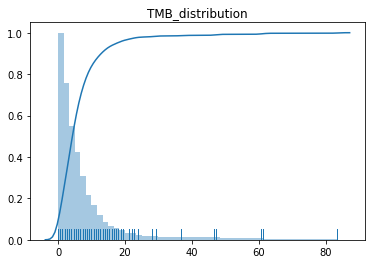

In [63]:
sns.distplot(df_out[['TMB']], hist_kws=dict(cumulative=-1), kde_kws=dict(cumulative=-1), rug=True).set_title('TMB_distribution')

## Modify AAchange files

In [93]:
AA_path = in_path + '/somatic/overlap'
AA_outdir = outdir + '/modified_AAchange'
os.makedirs(AA_outdir, exist_ok=True)
os.chdir(AA_path)
sample_pair = glob('*')
skip_file(sample_pair)

In [94]:
for pair in sample_pair:
    file = glob(f'{pair}/*snv.sindel.AAchange.xls')[0]
    our_file = f'{AA_outdir}/{pair}.byExon.AAchange.xls'
    out_line = ''
    lnum = 0
    with open(file, 'r') as f:
        for l in f:
            lnum += 1
            if re.match('^Chr', l):
                out_line += l;
                continue
            l = l.split('\t')
            pos = l[1]; gname = l[5]
            exon = 0
            if gname in gene_dic:
                for p1,p2 in gene_dic[gname]:
                    exon+=1
                    if pos>=p1 and pos<=p2:
                        l[5] = "%s_%s" %(gname, exon)
                        break
                out_line += '\t'.join(l)
            else:
                out_line += '\t'.join(l)
    if lnum<=1 or lnum>26:
        continue
    with open(our_file, 'w') as ofh:
        ofh.write(out_line)

## Modify icgc files

In [8]:
#icgc_files = glob('/mnt/cfs/project/rd/med/ctdna/panel/tmb/icgc.*.bed')
icgc_files = glob('/mnt/cfs/project/rd/med/ctdna/panel/tmb/yuceone/validate/select.bed')
icgc_outdir = outdir + '/modified_icgc_bed'
os.makedirs(icgc_outdir, exist_ok=True)
for file in icgc_files:
    name = os.path.basename(file)
    outfile = f'{icgc_outdir}/{name}'
    with open(outfile, 'w') as of:
        with open(file, 'r') as f:
            for line in f:
                l = line.strip().split('\t')
                if not re.match(r'chr', l[0], re.I):
                    Chr = f'chr{l[0]}'
                else:
                    Chr = l[0]
                for gene in gene_dic.keys():
                    num = 0
                    for p1,p2 in gene_dic[gene]:
                        num+=1
                        if Chr == gene_chr[gene] and (l[1]>=p1 and l[2]<=p2):
                            line = line.strip() + f'\t{gene}_{num}\n'
                of.write(line)

## calculate TMB

### 各方法选择不同数量外显子突变占比变化

In [17]:
AA_path = in_path + '/somatic/overlap'
AA_outdir = outdir + '/modified_AAchange'
os.chdir(AA_outdir)
index = !ls |sed 's/.byExon.AAchange.xls//'
mut_tot = !wc -l *.byExon.AAchange.xls |awk '{print $1}'
del mut_tot[-1]
mut_tot = np.array(mut_tot, dtype=np.int16)
mut_tot = mut_tot - 1

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa9881674e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa988167da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa988167390>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa988177630>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa988177a58>],
 'means': []}

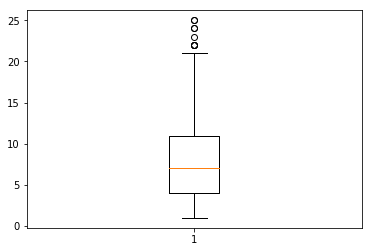

In [10]:
plt.boxplot(mut_tot)

In [18]:
exon_files = []
methods = ['byVar', 'byCosine']
titles = ['byVar', 'byCosine']
for i in methods:
    #exon_files.extend(glob(f'{outdir}/Exon/1.most_various_exon_{i}'))
    exon_files.extend(glob(f'{outdir}/Exon/most_various_exon_{i}'))
exon_num = file_lineNum(exon_files[0])

In [19]:
def mut_count(exons_for_count):
    mut_by_exon = []
    for i in index:
        with open(f'{i}.byExon.AAchange.xls', 'r') as f:
            f.readline()
            ct = 0
            for l in f:
                gname = l.split('\t')[5]
                if gname in exons_for_count:
                    ct += 1
            mut_by_exon.append(ct)
    return(mut_by_exon)

In [20]:
# 部分样品由于突变数少，结果极端，故取中位数
medPercentage = []
for file in exon_files:
    local_avgp = []
    for i in range(2,exon_num+1):
        exons_for_count = !sed -n '2,{i}'p {file} |cut -f1
        mut_by_exon = mut_count(exons_for_count)
        local_avgp.append(np.median(mut_by_exon/mut_tot))
    medPercentage.append(local_avgp)

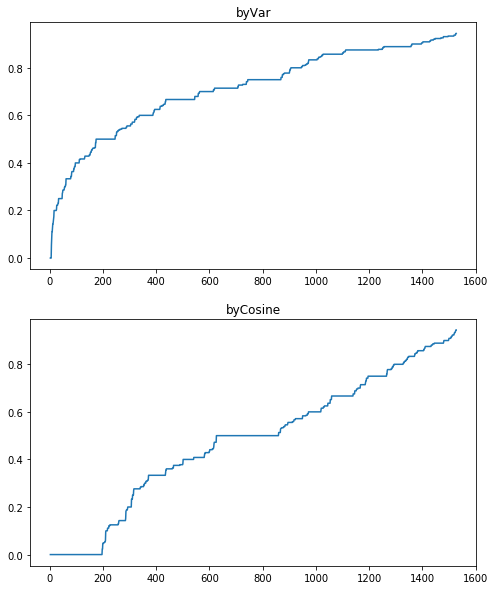

In [21]:
# 随使用外显子数目增加，突变计数占总突变数的比例中位数变化趋势
plt.figure(figsize=(8,10))
x = list(range(2,exon_num+1))
for i in range(len(exon_files)):
    y = medPercentage[i]
    num = i + 1
    plt.subplot(f'21{num}')
    plt.plot(x, y)
    plt.title(titles[i])
plt.show()

# 由图发现，Cosine实际筛选出来的是突变发现数频率很小的外显子

In [ ]:
n = 0
for i in medPercentage[2][:100]:
    print(i, end=' ')
    if i > 0.05:
        print(f'\ntake {n} exons')
        break
    n+=1

In [ ]:
new_cols = !sed -n '2,91'p {outdir}/Exon/most_various_exon_byCosine |cut -f1
ndf = exonNum_df[new_cols]
ndf.sum()

### 前180个外显子

In [74]:
fnum = 390 + 1

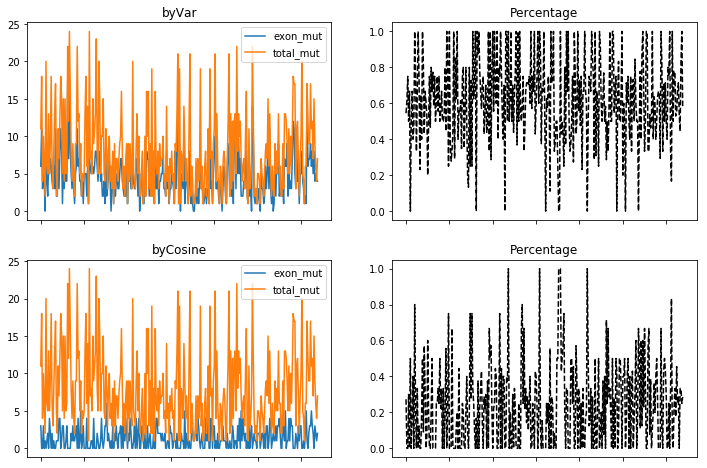

In [75]:
# 计数到外显子数占总突变数比例
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
for i,file in enumerate(exon_files):
    exons_for_count = !sed -n '2,{fnum}'p {file} |cut -f1
    mut_by_exon = mut_count(exons_for_count)
    df_mut = pd.DataFrame({'total_mut':mut_tot, 'exon_mut':mut_by_exon}, index=index)
    df_mut['percentage'] = np.round(df_mut.exon_mut / df_mut.total_mut, 3)
    #df_mut['difference'] = df_mut.total_mut - df_mut.exon_mut
    #corr = df_mut[['exon_mut','total_mut']].corr().iloc[0,1]
    df_mut[['exon_mut','total_mut']].plot(title=titles[i], ax=axes[i,0])
    df_mut['percentage'].plot(title='Percentage', style='k--', ax=axes[i,1])
plt.show()

/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has bee

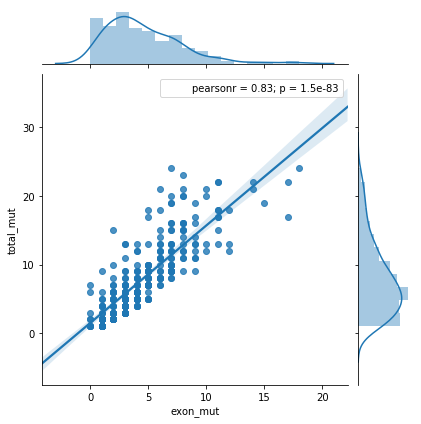

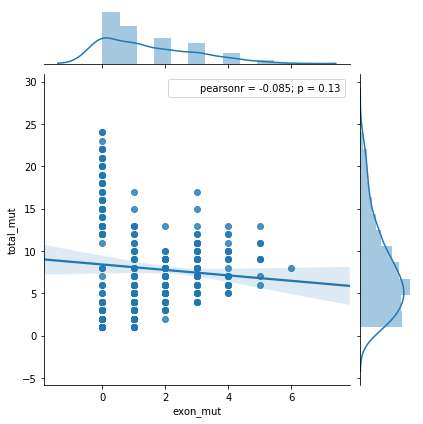

In [76]:
#f, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
for i,file in enumerate(exon_files):
    exons_for_count = !sed -n '2,{fnum}'p {file} |cut -f1
    mut_by_exon = mut_count(exons_for_count)
    df_mut = pd.DataFrame({'total_mut':mut_tot, 'exon_mut':mut_by_exon}, index=index)
    sns.jointplot(x='exon_mut', y='total_mut', data=df_mut, kind='reg')
plt.show()

### 前390个外显子

In [138]:
fnum = 380 + 1

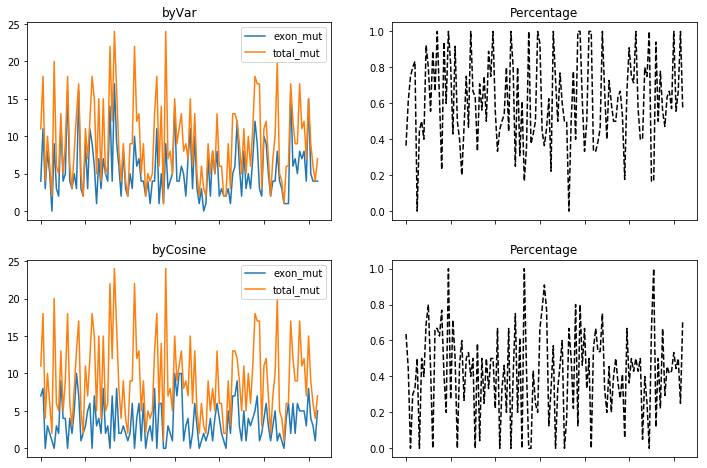

In [139]:
# 计数到外显子数占总突变数比例
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
for i,file in enumerate(exon_files):
    exons_for_count = !sed -n '2,{fnum}'p {file} |cut -f1
    mut_by_exon = mut_count(exons_for_count)
    df_mut = pd.DataFrame({'total_mut':mut_tot, 'exon_mut':mut_by_exon}, index=index)
    df_mut['percentage'] = np.round(df_mut.exon_mut / df_mut.total_mut, 3)
    #df_mut['difference'] = df_mut.total_mut - df_mut.exon_mut
    #corr = df_mut[['exon_mut','total_mut']].corr().iloc[0,1]
    df_mut[['exon_mut','total_mut']].plot(title=titles[i], ax=axes[i,0])
    df_mut['percentage'].plot(title='Percentage', style='k--', ax=axes[i,1])
plt.show()

/mnt/nfs/user/danxu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/mnt/nfs/user/danxu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/mnt/nfs/user/danxu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/mnt/nfs/user/danxu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


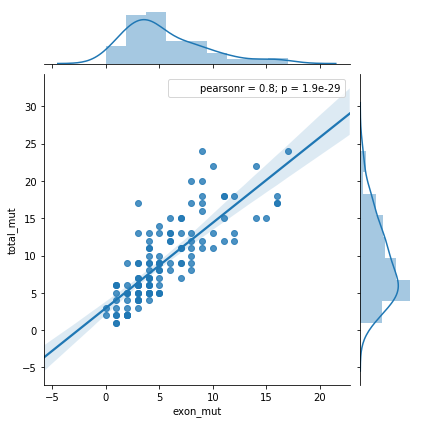

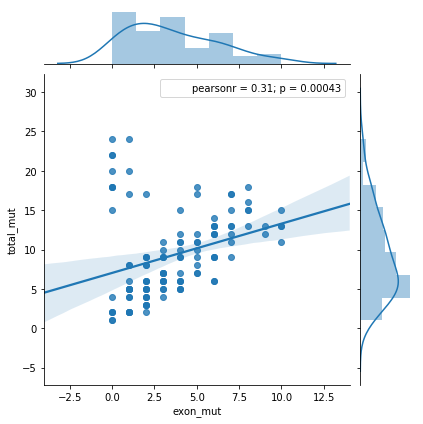

In [140]:
#f, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
for i,file in enumerate(exon_files):
    exons_for_count = !sed -n '2,{fnum}'p {file} |cut -f1
    mut_by_exon = mut_count(exons_for_count)
    df_mut = pd.DataFrame({'total_mut':mut_tot, 'exon_mut':mut_by_exon}, index=index)
    sns.jointplot(x='exon_mut', y='total_mut', data=df_mut, kind='reg')
plt.show()

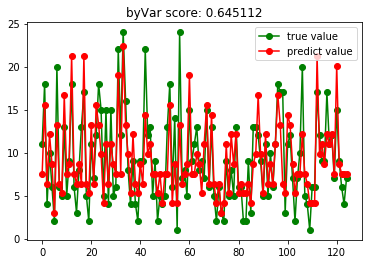

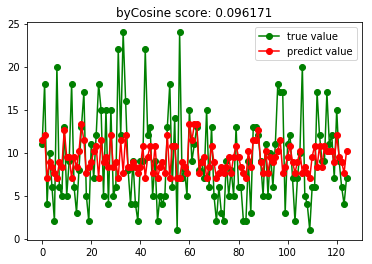

In [141]:
for i,file in enumerate(exon_files):
    exons_for_count = !sed -n '2,{fnum}p' {file} |cut -f1
    mut_by_exon = mut_count(exons_for_count)
    x_train = np.reshape(mut_by_exon, (-1,1))
    y_train = mut_tot
    x_test = x_train
    y_test = y_train
    try_method(linear_model.LinearRegression(), titles[i])

### 外源外显子

In [81]:
icgc_outdir = outdir + '/modified_icgc_bed'
icgc_files = glob(f'{icgc_outdir}/*.bed')
row_num = len(icgc_files)
ex_titles = [os.path.basename(i) for i in icgc_files]

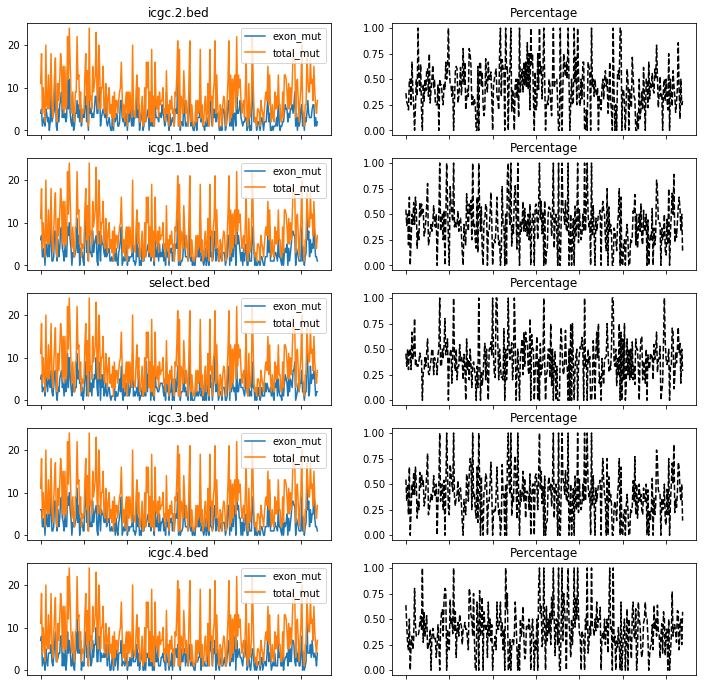

In [82]:
f, axes = plt.subplots(nrows=row_num, ncols=2, figsize=(12,12))
for i,file in enumerate(icgc_files):
    exons_for_count = !cut -f4 {file}
    exons_for_count.remove('')
    mut_by_exon = mut_count(exons_for_count)
    df_mut = pd.DataFrame({'total_mut':mut_tot, 'exon_mut':mut_by_exon}, index=index)
    df_mut['percentage'] = np.round(df_mut.exon_mut / df_mut.total_mut, 3)
    #df_mut['difference'] = df_mut.total_mut - df_mut.exon_mut
    #corr = df_mut[['exon_mut','total_mut']].corr().iloc[0,1]
    df_mut[['exon_mut','total_mut']].plot(title=ex_titles[i], ax=axes[i,0])
    df_mut['percentage'].plot(title='Percentage', style='k--', ax=axes[i,1])
plt.show()

/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has bee

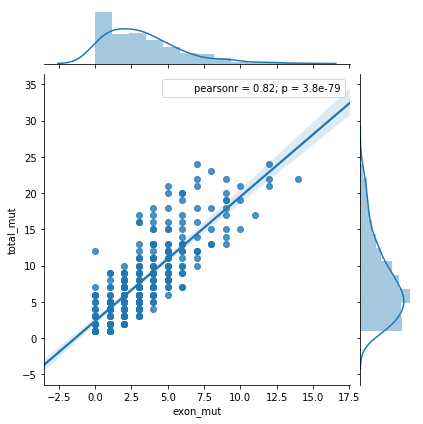

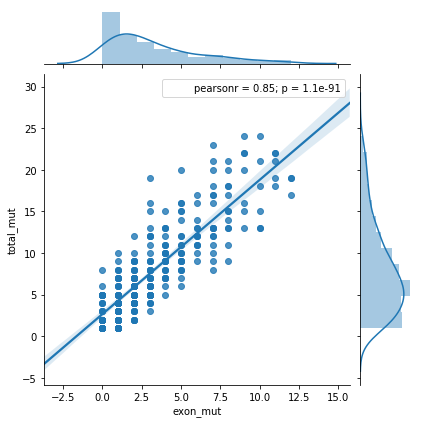

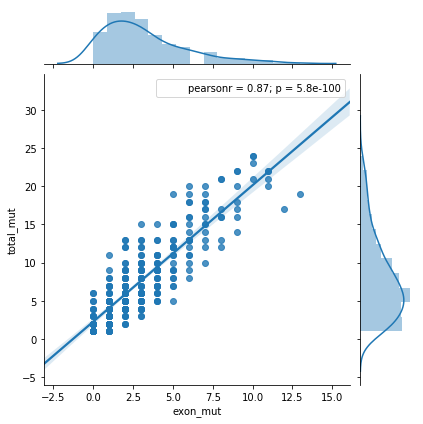

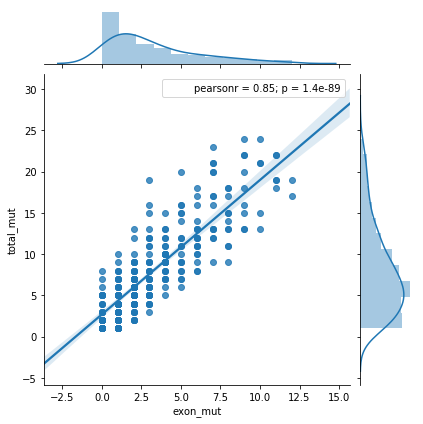

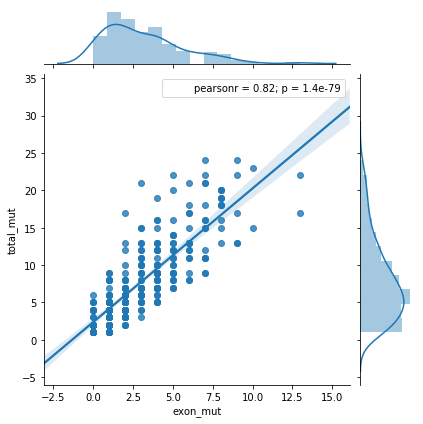

In [83]:
for i,file in enumerate(icgc_files):
    exons_for_count = !cut -f4 {file}
    exons_for_count.remove('')
    mut_by_exon = mut_count(exons_for_count)
    df_mut = pd.DataFrame({'total_mut':mut_tot, 'exon_mut':mut_by_exon}, index=index)
    sns.jointplot(x='exon_mut', y='total_mut', data=df_mut, kind='reg')
plt.show()

### Cosine [200:611]

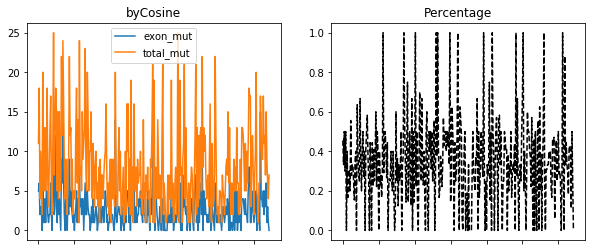

In [40]:
# 计数到外显子数占总突变数比例
select = '200,611'
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
i = 1
file = exon_files[i]
exons_for_count = !sed -n '{select}p' {file} |cut -f1
mut_by_exon = mut_count(exons_for_count)
df_mut = pd.DataFrame({'total_mut':mut_tot, 'exon_mut':mut_by_exon}, index=index)
df_mut['percentage'] = np.round(df_mut.exon_mut / df_mut.total_mut, 3)
df_mut['difference'] = df_mut.total_mut - df_mut.exon_mut
#corr = df_mut[['exon_mut','total_mut']].corr().iloc[0,1]
df_mut[['exon_mut','total_mut']].plot(title=titles[i], ax=axes[0])
df_mut['percentage'].plot(title='Percentage', style='k--', ax=axes[1])
plt.show()

/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/danxu/3.software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


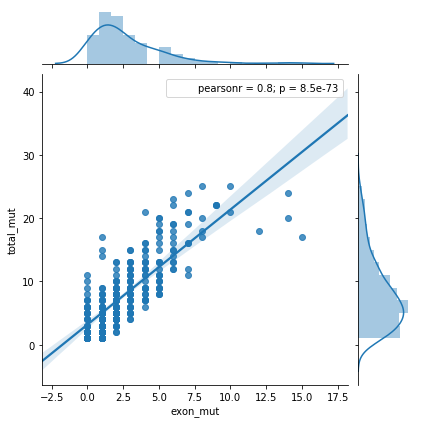

In [41]:
#f, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
i = 1
file = exon_files[i]
exons_for_count = !sed -n '{select}p' {file} |cut -f1
mut_by_exon = mut_count(exons_for_count)
df_mut = pd.DataFrame({'total_mut':mut_tot, 'exon_mut':mut_by_exon}, index=index)
#df_mut['percentage'] = np.round(df_mut.exon_mut / df_mut.total_mut, 3)
df_mut['difference'] = df_mut.total_mut - df_mut.exon_mut
#corr = df_mut[['exon_mut','total_mut']].corr().iloc[0,1]
#df_mut[['exon_mut','total_mut','percentage']].plot(title=titles[i], ax=axes[i,0], secondary_y='percentage')
sns.jointplot(x='exon_mut', y='total_mut', data=df_mut, kind='reg')
plt.show()

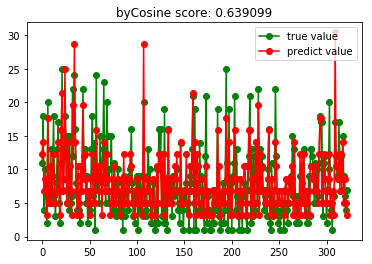

In [42]:
i=1
file = exon_files[i]
exons_for_count = !sed -n '{select}p' {file} |cut -f1
mut_by_exon = mut_count(exons_for_count)
x_train = np.reshape(mut_by_exon, (-1,1))
y_train = mut_tot
x_test = x_train
y_test = y_train
try_method(linear_model.LinearRegression(), titles[i])

### 回归

In [27]:
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import r2_score

In [ ]:
pca = PCA(n_components=3)
exon_pca = pca.fit(ndf.T)
exon_pca.explained_variance_

In [25]:
def try_method(model, title):
    model.fit(x_train,y_train)
    score = model.score(x_test, y_test)
    result = model.predict(x_test)
    plt.figure()
    plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('%s score: %f'%(title,score))
    plt.legend()
    plt.show()

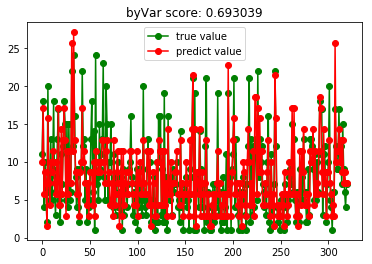

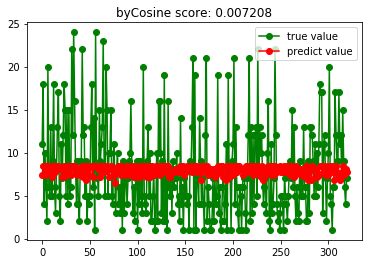

In [79]:
for i,file in enumerate(exon_files):
    exons_for_count = !sed -n '2,{fnum}p' {file} |cut -f1
    mut_by_exon = mut_count(exons_for_count)
    x_train = np.reshape(mut_by_exon, (-1,1))
    y_train = mut_tot
    x_test = x_train
    y_test = y_train
    try_method(linear_model.LinearRegression(), titles[i])

#### 去掉占比100%的观测项

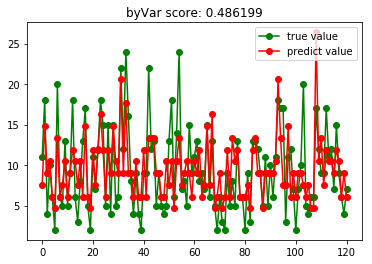

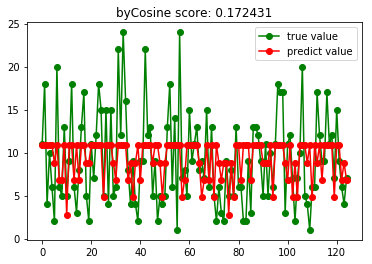

In [27]:
for i,file in enumerate(exon_files):
    exons_for_count = !sed -n '2,{fnum}p' {file} |cut -f1
    mut_by_exon = mut_count(exons_for_count)
    x_train = np.reshape(mut_by_exon, (-1,1))
    y_train = mut_tot
    yp_train = (np.round(mut_by_exon / mut_tot, 3))
    not_100 = yp_train != 1
    x_train = x_train[not_100]
    y_train = y_train[not_100]
    x_test = x_train
    y_test = y_train
    try_method(linear_model.LinearRegression(), titles[i])

#### 外源外显子

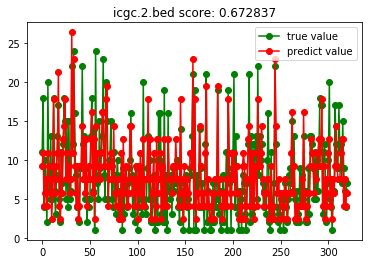

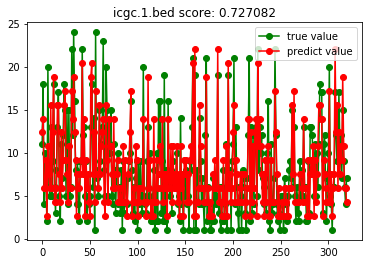

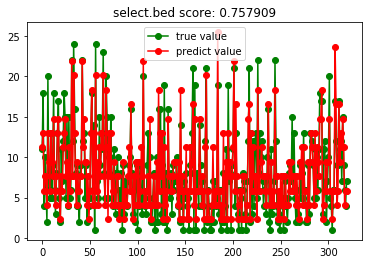

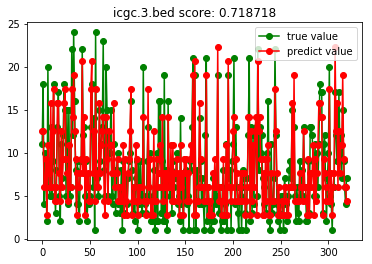

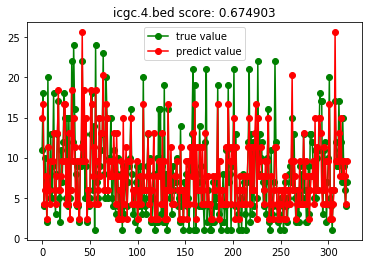

In [85]:
for i,file in enumerate(icgc_files):
    exons_for_count = !cut -f4 {file}
    exons_for_count.remove('')
    mut_by_exon = mut_count(exons_for_count)
    x_train = np.reshape(mut_by_exon, (-1,1))
    y_train = mut_tot
    x_test = x_train
    y_test = y_train
    try_method(linear_model.LinearRegression(), ex_titles[i])

### 外源外显子统计占比

In [86]:
Cos_exons = !sed -n '2,{fnum}'p {exon_files[0]} |cut -f1

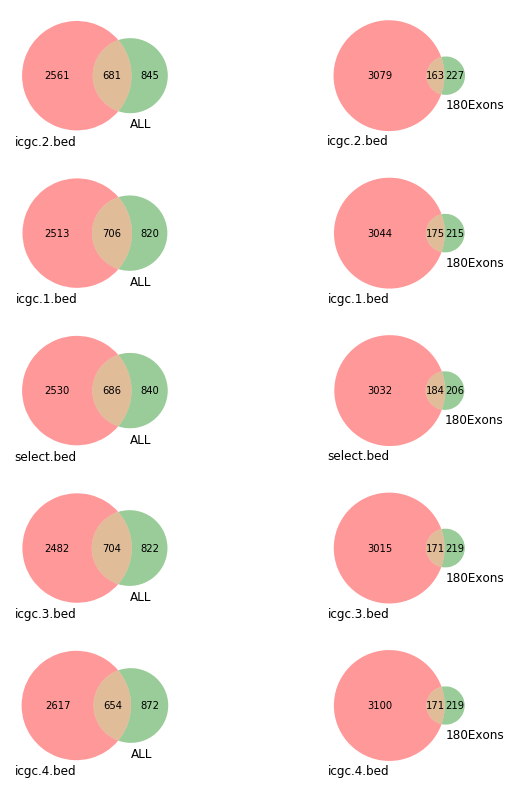

In [87]:
from matplotlib_venn import venn2
f ,ax = plt.subplots(nrows=row_num, ncols=2, figsize=(10,14))
for i,file in enumerate(icgc_files):
    exons_for_count = !cut -f4 {file}
    venn2([set(exons_for_count), set(all_exome)], set_labels=(ex_titles[i], 'ALL'), ax=ax[i][0])
#    ax[i][0].set_title(f'{ex_titles[i]}-VS-All_Var_Exons')
    venn2([set(exons_for_count), set(Cos_exons)], set_labels=(ex_titles[i], '180Exons'), ax=ax[i][1])
#    ax[i][1].set_title(f'{ex_titles[i]}-VS-180_Var_Exons')